In [1]:
# Third-party imports
import matplotlib.pyplot as plt
import pandas as pd

# Project imports
import twinlab_client as tl


      == Client Initialisation ==
      Local Server  : http://localhost:3000
      Cloud Server  : https://z2seun1aee.execute-api.eu-west-2.amazonaws.com/Prod
      Group Name    : digilab
      User Name     : mead
      


In [2]:
# File paths
campaign_dir = "./../campaigns/ukaea/"
datasets_dir = "./../datasets/"
file_train = datasets_dir + "ukaea_small.csv"
file_grid = "data/ukaea/grid.csv"
# file_eval = campaign_dir + "eval.csv"
# file_eval = campaign_dir + "gen.csv"
file_eval = campaign_dir + "test.csv"

# Campaign id
campaign_id = "ukaea"

# Server
# server = "local"
server = "cloud"

In [3]:
# Load training and evaluation data (for plotting purposes)
df_train = pd.read_csv(file_train)
df_eval = pd.read_csv(file_eval)
df_grid = pd.read_csv(file_grid, header=None)

In [4]:
# Column headings for outputs
y_outputs = [f"y{i}" for i in range(len(df_grid))]

# Parameters
params = {
    "filename": "ukaea_small.csv",
    "inputs": ["E1", "E2", "E3", "n1", "n2"],
    "outputs": y_outputs,
    "train_test_split": len(df_train),
    "decompose_outputs": True,
}

In [5]:
# Upload dataset to cloud
tl.upload_dataset(file_train, server=server, verbose=True)

Response text:
{'message': 'ukaea_small.csv uploaded successfully'}



In [6]:
# List datasets to check that the upload worked
tl.list_datasets(server=server, verbose=True)

Response text:
{'message': "Datasets: ['basic.csv', 'leaf_spring.csv', 'ukaea_small.csv']"}



In [7]:
# Train campaign
# TODO: You get an error message here when the request times out
tl.train_campaign(params, campaign_id, server=server, verbose=True)

Response text:
{'message': 'Training complete'}



In [8]:
# List campaigns to sanity check upload
tl.list_campaigns(server=server, verbose=True)

Response text:
{'message': "Campaigns: {'ukaea'}"}



In [9]:
# Sample from emulator
df_mean, df_std = tl.sample_campaign(file_eval, campaign_id, server=server, verbose=False)

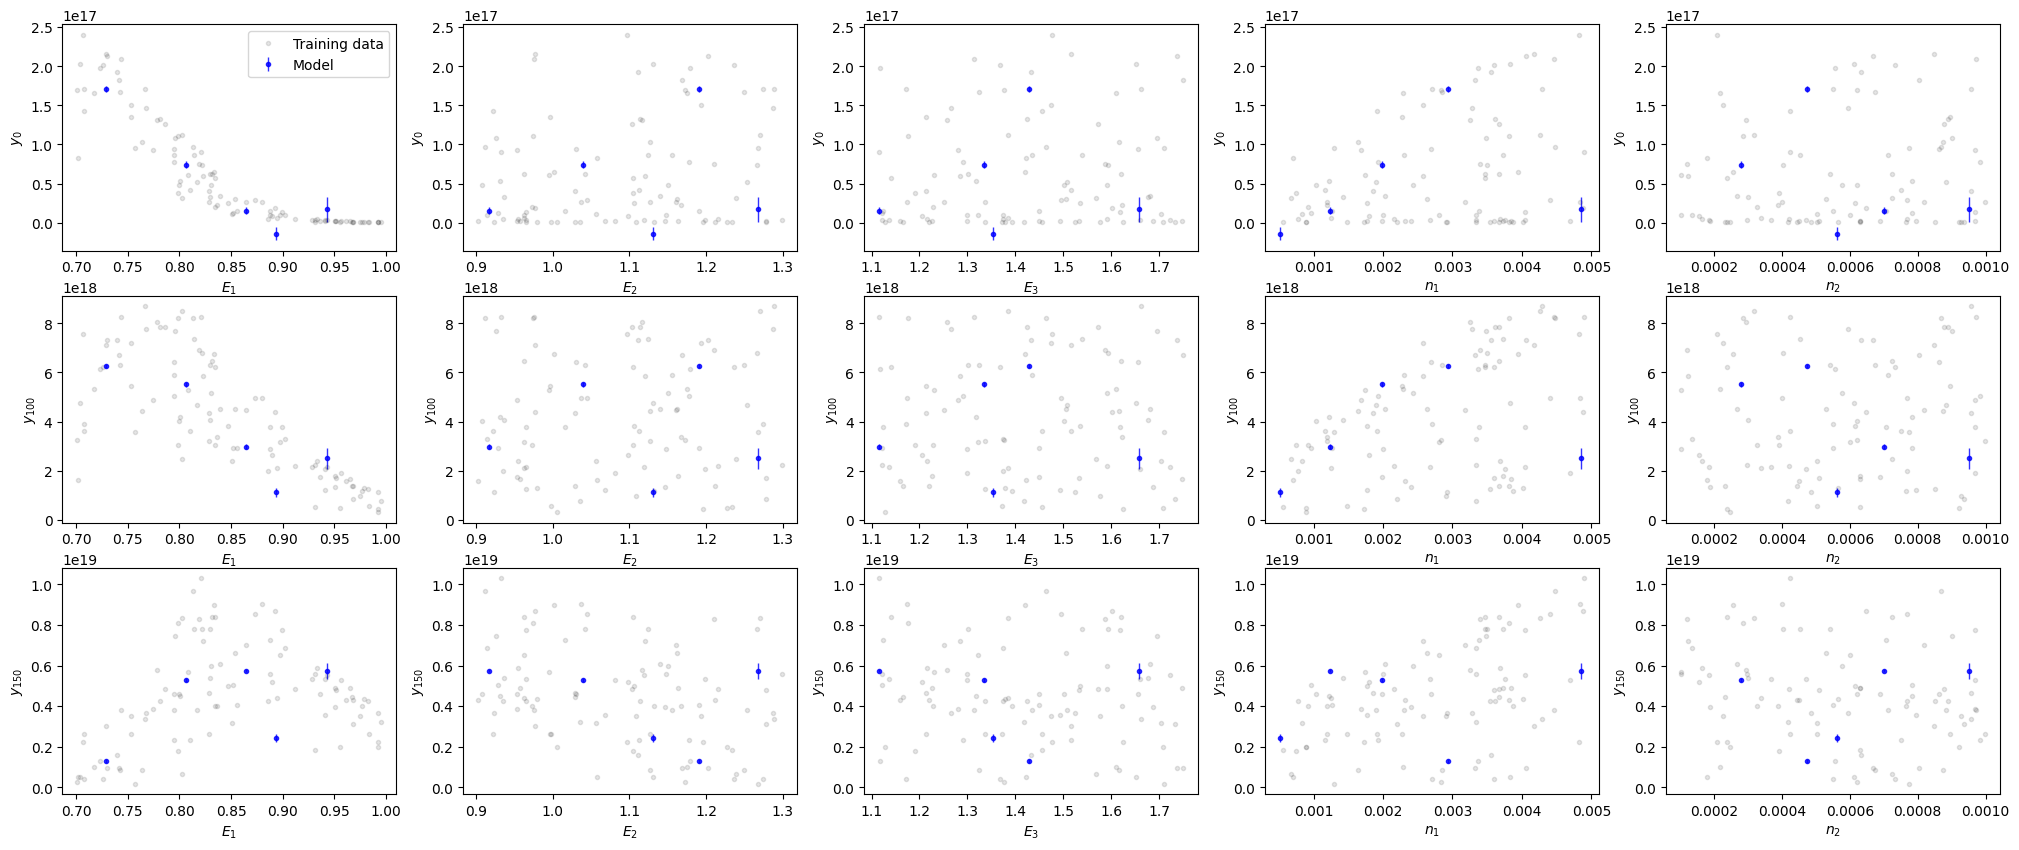

In [10]:
# Parameters for plot
color = "blue"
alpha = 0.8
xs = {"E1": r"$E_{1}$", "E2": r"$E_{2}$", "E3": r"$E_{3}$", "n1": r"$n_{1}$", "n2": r"$n_{2}$"}
ys = {f"y{i}": fr"$y_{{{i}}}$" for i in [0, 100, 150]}

# Plot some examples
nrow, ncol = len(ys), len(xs)
plt.subplots(nrow, ncol, figsize=(25, 10))
nplot = 0
for y, y_label in ys.items():
    for x, x_label in xs.items():
        nplot += 1
        plt.subplot(nrow, ncol, nplot)
        plt.errorbar(df_eval[x], df_mean[y], yerr=df_std[y], marker='.', lw=1, ls='None', color=color, alpha=alpha, label="Model")
        plt.plot(df_train[x], df_train[y], ".", color="black", alpha=0.1, label="Training data")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        if nplot==1: plt.legend()
plt.show()

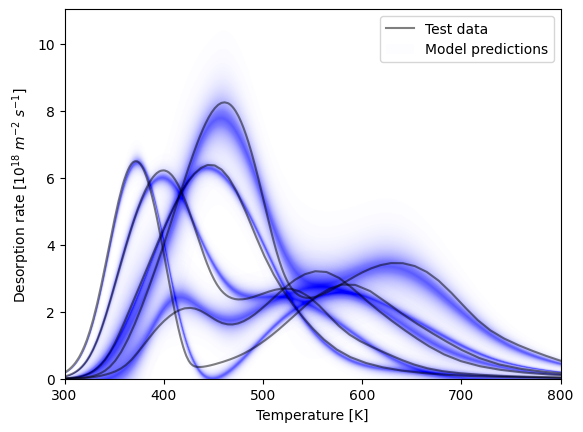

In [22]:
# Parameters for pot
error_inflation_factor = 1. # Factor to multiply error by for plotting
y_fac = 18 # Factor to divide y by for plotting [log10]
plot_model_mean = False
plot_model_blur = True
model_color = 'blue'
number_of_training_examples = 0
number_of_model_examples = 5

# Plot results
grid = df_grid.iloc[:, 0]
plt.subplots()
for example in range(number_of_training_examples): # Training examples
    train = df_train[y_outputs].iloc[example]/10**y_fac
    label = "Example training data" if example==0 else None
    plt.plot(grid, train, color='black', alpha=0.5, label=label)
for example in range(number_of_model_examples): # Model predictions
    mean = df_mean[y_outputs].iloc[example]/10**y_fac
    err = error_inflation_factor*df_std[y_outputs].iloc[example]/10**y_fac
    if file_eval == campaign_dir + "test.csv":
        eval = df_eval[y_outputs].iloc[example]/10**y_fac
        label = "Test data" if example==0 else None
        plt.plot(grid, eval, color='black', alpha=0.5, label=label)
    if plot_model_mean:
        label = "Model predictions" if example==0 else None
        plt.plot(grid, mean, color=model_color, label=label, alpha=0.1)
    if plot_model_blur:
        n = 100
        alpha = tl.get_alpha(n, 0.5)
        dys = tl.get_boundaries(n)
        for dy in dys:
            label = "Model predictions" if example==0 and dy==dys[0] and not plot_model_mean else None
            plt.fill_between(grid, mean-dy*err, mean+dy*err, color=model_color, alpha=alpha, lw=0., label=label)
plt.xlabel(r'Temperature [K]')
plt.xlim((grid.min(), grid.max()))
plt.ylabel(rf"Desorption rate [$10^{{{y_fac}}}$ $m^{{{-2}}}$ $s^{{{-1}}}$]")
plt.ylim(bottom=0.)
plt.legend()
plt.show()

In [ ]:
# Delete campaign
tl.delete_campaign(campaign_id, server=server, verbose=True)